In [70]:
#Primary Jupyter python script for analysis of BAG file data from IGVC runs. Made by 2LT John Oberholtzer
#Updated 03JUN2016

#Checklist for operation:
#1. Change "Suffix" to appropriate ending from runs.
#2. Change the booleans on the FLAG list below to correspond with which BAG files are available. Adjust as necessary.
#3. Comment or otherwise disable any tests you do not wish to run in their corresponding cells.
#4. Click Cells>Run All to execute

#This file will require updating if rostopics are moved from one bag file to another as the references are hardcoded.
import matplotlib
import csv
import sys
import ast
import os
import time
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
from datetime import datetime
from struct import *
from mpl_toolkits.mplot3d import Axes3D
from LatLongUTMconversion import LLtoUTM
csv.field_size_limit(sys.maxsize)
#matplotlib.use('Agg')
%matplotlib nbagg
pylab.rcParams['figure.figsize'] = 15, 8  # that's default image size for this interactive session

#The folder the BAG files are in should be named as RUN + the suffix. Example: RUN_2016-05-26-10-34-51
#bagfolder = "RUN" + suffix + "/"
datafolder = "Data/square/"

In [71]:
#Load INSPVAA messages from the KVH CSV files.
#If aware that .CSV files are not present, you can optionally manually uncheck the flags from the above cell,
#although the code will automatically check and set the flags to False where .CSV files are not present.
inspvafile = "kvh_INSPVAA.csv"
FLAG_inspvafile = True
InspvaArray = []
if (os.path.isfile(datafolder+inspvafile) == False):
    FLAG_inspvafile = False
    print("File not found: " + datafolder+inspvafile)
else:    
    with open((datafolder+inspvafile),'rb') as infile:
        content = infile.readlines()
        for row in content:
            #if ('\0' not in row) and (('BESTGNSSPOSA'in row) or ('INSPVAA'in row)): # remove unparsed bytes found when in SBAS mode.
            if (('BESTGNSSPOSA'in row) or ('INSPVAA'in row)): # remove unparsed bytes found when in SBAS mode.
                if ('\0' not in row):
                    InspvaArray.append(row.split(','))
                else:
                    row=row.split('#')[-1].split(',') 
                    row[0]='#'+row[0]
                    InspvaArray.append(row)             
    print("Found file: " + datafolder+inspvafile + " with " + str(len(InspvaArray))+ " rows of data.")
    print InspvaArray[4]
    

Found file: Data/circle05/kvh_INSPVAA.csv with 2945 rows of data.
['#INSPVAA', 'COM1', '0', '75.5', 'FINESTEERING', '2925', '421764.200', '00004000', '54e2', '13755;2925', '421764.200000000', '41.39499825278', '-73.95549215922', '7.5488', '0.0336', '0.0080', '0.0050', '-1.125948839', '0.372430312', '184.235417843', 'INS_SOLUTION_GOOD', '425463a7\r\n']


In [72]:
#INSPVAA Lat and Long PROCESSING (RUN IF USING ANALYSIS)
inspva_latitudes= []
inspva_longitudes= []
inspva_altitudes= [] 
gnss_latitudes= []
gnss_longitudes= []
gnss_altitudes= [] 
if FLAG_inspvafile == True:
    TFcolumnnames = InspvaArray.pop(0)
    TFdataex = InspvaArray[0]    
   
    for row in InspvaArray:
        if ('#INSPVAA'==row[0]):
            if ('FINESTEERING'==row[4]) and ('INS_SOLUTION_GOOD'==row[20]):
                inspva_latitudes.append(row[11])
                inspva_longitudes.append(row[12])
                inspva_altitudes.append(row[13])  
        if ('#BESTGNSSPOSA'==row[0]):
            if ('FINESTEERING'==row[4]):
                gnss_latitudes.append(row[11])
                gnss_longitudes.append(row[12])
                gnss_altitudes.append(row[13])                  
    print row[0],row[1]

    print len(InspvaArray),len(inspva_latitudes),TFcolumnnames,'/n',TFdataex

#INSPVAA COM1
2944 2392 ['#BESTGNSSPOSA', 'COM1', '0', '76.0', 'FINESTEERING', '2925', '421763.000', '00004000', 'bede', '13755;SOL_COMPUTED', 'WAAS', '41.39487735675', '-73.95503267530', '52.7760', '-32.2000', 'WGS84', '0.7979', '0.6458', '1.4448', '"133"', '4.000', '0.000', '13', '10', '10', '10', '00', '86', '00', '03', '9ac65bac\r\n'] /n ['[COM1]#INSPVAA', 'COM1', '0', '75.5', 'FINESTEERING', '2925', '421763.800', '00004000', '54e2', '13755;2925', '421763.800000000', '41.39499825933', '-73.95549217680', '7.5488', '0.0009', '0.0049', '-0.0042', '-1.117605963', '0.346340875', '184.239143566', 'INS_SOLUTION_GOOD', '4eae3a04\r\n']


In [73]:
#Load FLEX6 messages from the FLEX6 GPS CSV files.

flex6_gpsfile = "flex6_gps.csv"
FLAG_flex6_gps = True
flex6_gpsArray = []
if (os.path.isfile(datafolder+flex6_gpsfile) == False):
    FLAG_inspvafile = False
    print("File not found: " + datafolder+flex6_gpsfile)
else:    
    with open((datafolder+flex6_gpsfile),'rb') as infile:
        content = infile.readlines()
        for row in content:
            #if ('\0' not in row) and (('BESTGNSSPOSA'in row) or ('INSPVAA'in row)): # remove unparsed bytes found when in SBAS mode.
            if (('BESTPOSA'in row)): # remove unparsed bytes found when in SBAS mode.
                    #row=row.split('#')[-1].split(',') 
                    #row[0]='#'+row[0]
                    flex6_gpsArray.append(row.split(','))             
    print("Found file: " + datafolder+flex6_gpsfile + " with " + str(len(flex6_gpsArray))+ " rows of data.")
    print flex6_gpsArray[4]

Found file: Data/circle05/flex6_gps.csv with 490 rows of data.
['#BESTPOSA', 'USB2', '0', '88.5', 'FINESTEERING', '1901', '421769.000', '00040000', '7145', '10985;SOL_COMPUTED', 'WAAS', '41.39486892954', '-73.95504491705', '51.6241', '-32.2000', 'WGS84', '1.4061', '0.9898', '2.6628', '"133"', '4.000', '0.000', '11', '8', '8', '8', '0', '06', '00', '03', '50bd28ef\r\n']


In [74]:
#INSPVAA Lat and Long PROCESSING (RUN IF USING ANALYSIS)
flex6_latitudes= []
flex6_longitudes= []
flex6_altitudes= [] 
if FLAG_flex6_gps == True:
    TFcolumnnames = flex6_gpsArray.pop(0)
    TFdataex = flex6_gpsArray[0]    
   
    for row in flex6_gpsArray:
                flex6_latitudes.append(row[11])
                flex6_longitudes.append(row[12])
                flex6_altitudes.append(row[13])                 
    print row[0],row[1]

    print len(flex6_gpsArray),len(flex6_latitudes),flex6_latitudes[9],flex6_longitudes[9],'/n',TFcolumnnames


#BESTPOSA USB2
489 489 41.39487056008 -73.95504334729 /n ['#BESTPOSA', 'USB2', '0', '86.0', 'FINESTEERING', '1901', '421765.000', '00040000', '7145', '10985;SOL_COMPUTED', 'WAAS', '41.39486914967', '-73.95504433395', '50.8962', '-32.2000', 'WGS84', '1.4068', '0.9899', '2.6843', '"133"', '5.000', '0.000', '11', '8', '8', '8', '0', '06', '00', '03', 'c589f775\r\n']


In [75]:
#Load mti-7000 messages from the Xsens CSV files.
mti700file = "mti700.csv"
FLAG_mti700file = True
mti700Array = []
newDict={}
mti700_latitudes= []
mti700_longitudes= []
mti700_altitudes= [] 
if (os.path.isfile(datafolder+mti700file) == False):
    FLAG_mti700file = False
    print("File not found: " + datafolder+mti700file)
else:    
    with open((datafolder+mti700file),'rb') as dictfile:        
        for line in dictfile:
            if 'Lat' in line:
                mti700Array.append(eval(line))
                mti700_latitudes.append((eval(line))['GNSS']['Lat'])
                mti700_longitudes.append((eval(line))['GNSS']['Lon'])
    print("Found file: " + datafolder+mti700file + " with " + str(len(mti700_latitudes))+ " rows of data.")
    print mti700Array[9]
    print mti700_latitudes[9]
    print mti700_longitudes[9]
    

Found file: Data/circle05/mti700.csv with 1924 rows of data.
{'GNSS': {'gDOP': 1.6500000000000001, 'tDOP': 0.73, 'gpsFix': 3, 'hour': 21, 'altMSL': 54, 'HeadAcc': 4073130, 'Lon': -73.9550579, 'pDOP': 1.47, 'month': 6, 'sec': 18, 'year': 2016, 'Hacc': 403, 'day': 16, 'nDOP': 0.64, 'vDOP': 1.21, 'hDOP': 0.8300000000000001, 'gspeed': 0, 'min': 9, 'altEllipsoid': 20, 'Sacc': 120, 'valid': 7, 'flags': 3, 'ITOW': 421775500, 'Vel_N': 0, 'Lat': 41.3948988, 'Vacc': 537, 'numSV': 10, 'tAcc': 1, 'Vel_E': 0, 'Vel_D': 0, 'eDOP': 0.54, 'nano': 500168788}, 'Timestamp': {'PacketCounter': 39314}}
41.3948988
-73.9550579


<IPython.core.display.Javascript object>


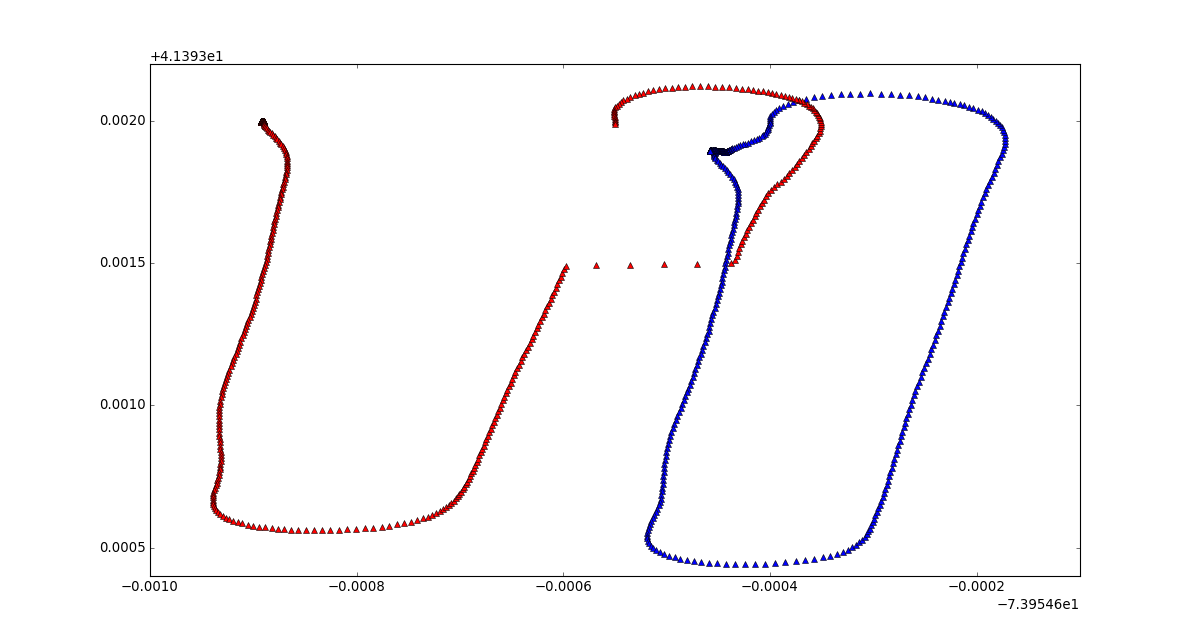

In [85]:
fig,ax = plt.subplots(1,1)

points=[(0,0),(4,4),(2,2),(2,3),(3,3),(3,2),(3,1),(2,1),(2,3),(1,3)]

#plt.plot(inspva_longitudes,inspva_latitudes, 'ro')
plt.show()   
for i in range((len(inspva_latitudes))/5):
    plt.plot(inspva_longitudes[i],inspva_latitudes[i],'r^')
    plt.plot(mti700_longitudes[i],mti700_latitudes[i], 'b^')
    fig.canvas.draw()
    time.sleep(0.2)
plt.show()    

In [77]:
#GPS AND ODOMGPS GRAPHING FOR LOCATION
#plt.ion()
#if FLAG_inspvafile == True:
#if False:
plt.plot(inspva_longitudes,inspva_latitudes, 'ro')
plt.plot(mti700_longitudes,mti700_latitudes, 'b^')
#plt.plot(gnss_longitudes,gnss_latitudes, 'g^')
#plt.plot(flex6_longitudes,flex6_latitudes, 'b*')
#plt.plot(-73.97545914722222,41.38231066666667,'b*') #Survey Point on Stony2
plt.show()
#for i in range(len(flex6_longitudes)):
    #plt.plot(float(flex6_longitudes[i]),float(flex6_latitudes[i]),'r*')
    #plt.show(block=False)
    #Z plt.draw()
    #time.sleep(0.01)
#plt.show()

